In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import becquerel as bq
from becquerel import Spectrum, rebin
from becquerel import SpectrumPlotter as sp

%matplotlib inline
np.random.seed(0)


def plot_rebin(bins, edges, lim=None):
    for b, e in zip(bins, edges):
        plt.plot(*sp.bin_edges_and_heights_to_steps(e, b))
        plt.fill_between(*sp.bin_edges_and_heights_to_steps(e, b), alpha=0.5)
    if lim:
        plt.gca().set_ylim(lim)


def plot_rebin_spec(specs, lim=None):
    fig, ax = plt.subplots()
    for s in specs:
        s.plot(ax=ax)
        s.fill_between(ax=ax, alpha=0.5)
    if lim:
        ax.set_ylim(lim)

## Rebinning module

Rebin can take in numpy arrays (both 1D and 2D, with the shape (number of spectra, number of bins) directly:

In [2]:
in_bins_1d = np.array([1, 2, 2, 3, 1, 0])
in_edges = np.array([0, 2, 4, 6, 8, 10, 12])
out_edges = np.array([0, 1, 3, 6, 7, 9])  # The edges does not have to be equally spaced

### Rebinning methods

there are two rebinning methods, `interpolation` and `listmode`  
- `interpolation`: assuming that the distribution within each bin is flat (or as specified in the `slopes` argument), put the proportion of counts into each of the corresponding new bins. Counts may become fractional after the rebinning, and this does not preserve Poisson statistics. (TODO: add how the `slopes` argument works)
- `listmode`: carries out a stochastic rebinning, by randomly sampling energies within each bin and binning all these energies into the new bin structure

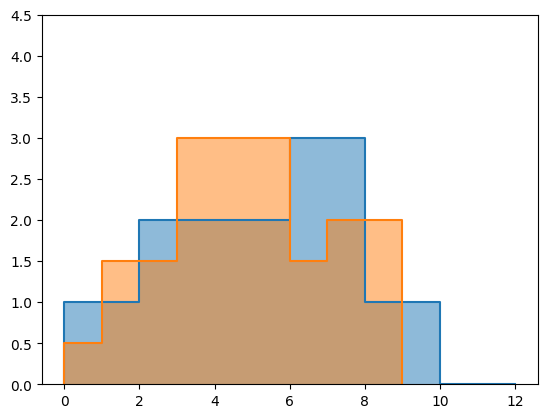

In [3]:
out_bins_1d = rebin(
    in_bins_1d, in_edges, out_edges, method="interpolation", slopes=None
)
plot_rebin([in_bins_1d, out_bins_1d], [in_edges, out_edges], lim=(0, 4.5))

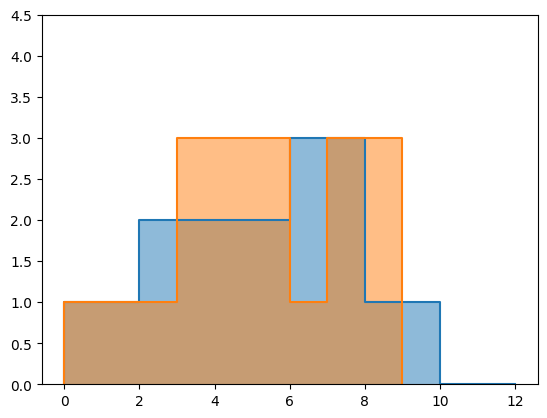

In [4]:
out_bins_1d = rebin(in_bins_1d, in_edges, out_edges, method="listmode", slopes=None)
plot_rebin([in_bins_1d, out_bins_1d], [in_edges, out_edges], lim=(0, 4.5))

### 2D Rebinning
You can rebin multiple spectra at the same time, too. The example uses the same input bin edges as the 1D example.

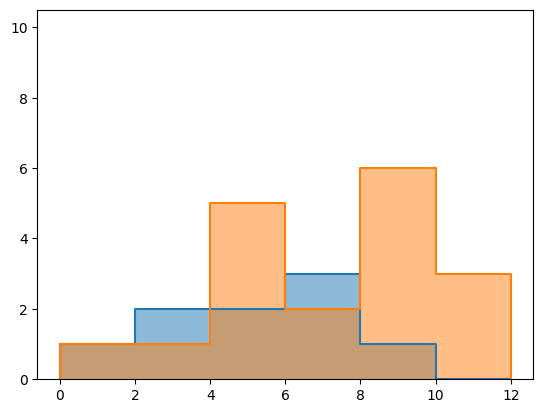

In [5]:
in_bins_2d = np.array([[1, 2, 2, 3, 1, 0], [1, 1, 5, 2, 6, 3]])
plot_rebin(in_bins_2d, [in_edges] * 2, lim=(0, 10.5))

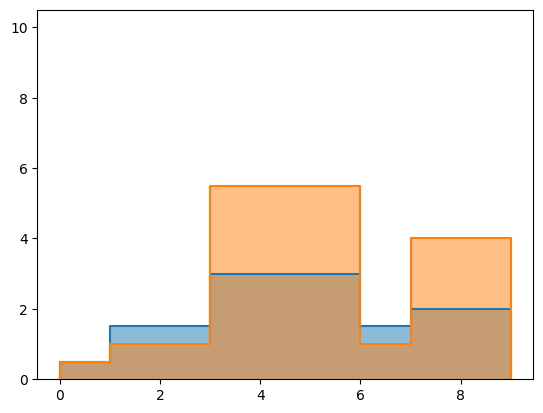

In [6]:
out_bins_2d = rebin(
    in_bins_2d, in_edges, out_edges, method="interpolation", slopes=None
)
plot_rebin(out_bins_2d, [out_edges] * 2, lim=(0, 10.5))

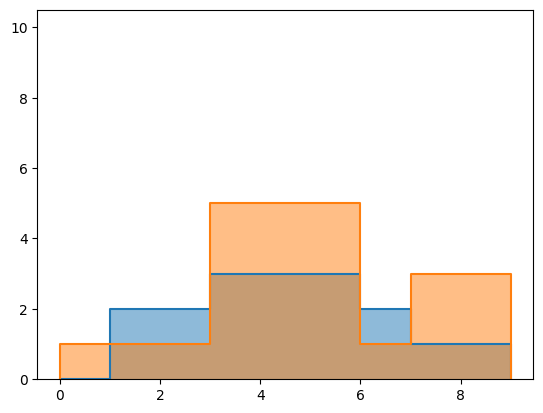

In [7]:
out_bins_2d = rebin(in_bins_2d, in_edges, out_edges, method="listmode", slopes=None)
plot_rebin(out_bins_2d, [out_edges] * 2, lim=(0, 10.5))

## Spectrum rebinning

It is possible to directly rebin a spectrum object

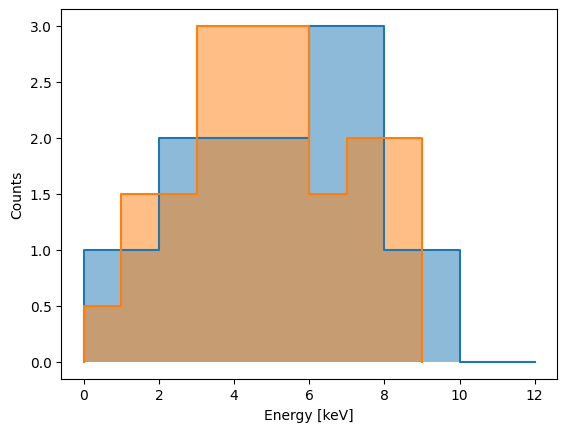

In [8]:
in_spec = Spectrum(in_bins_1d, bin_edges_kev=in_edges)
out_spec = in_spec.rebin(out_edges)
plot_rebin_spec([in_spec, out_spec])

There is also a `rebin_like` method, that takes another spectrum as argument and rebins according to that spectrum.

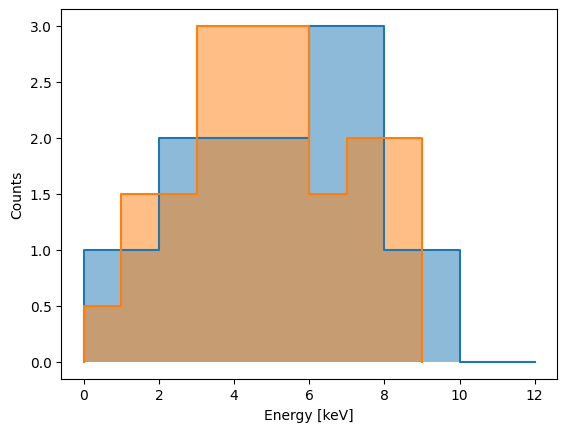

In [9]:
out_spec_like = in_spec.rebin_like(out_spec)
plot_rebin_spec([in_spec, out_spec])

## Usage with other packages than numpy

The rebin module can also be used with other packages such as `xarray`. But there is a bit more code involved to apply the rebinning algorithm in parallel as a `ufunc`. Also this doesn't perform any tests on the inputs. Lets first create a `xarray` data set. For this the `xarray` package needs to be installed.

In [10]:
in_bins_2d = xr.DataArray(
    [[1, 2, 2, 3, 1, 0], [1, 1, 5, 2, 6, 3]], dims=["spec", "bin"]
)

Lets redo the 'interpolation' example in 2d with the newely created `DataArray`.

becquerel/core/plotting.py:353: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y[1:-1:2] = heights.astype(float)
becquerel/core/plotting.py:354: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y[2:-1:2] = heights.astype(float)


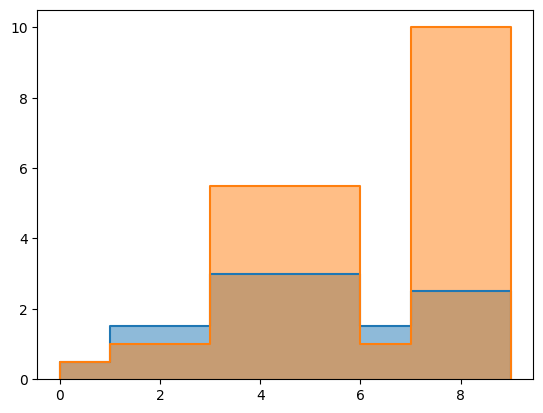

In [11]:
out_bins_2d = xr.apply_ufunc(
    bq.core.rebin._rebin_interpolation,
    in_bins_2d,
    in_edges,
    out_edges[:-1],
    np.zeros(6),
    input_core_dims=[["bin"], [], [], []],
    output_core_dims=[["out_bin"]],
    dask="parallelized",
    output_dtypes=[float],
)

plot_rebin(out_bins_2d, [out_edges] * 2, lim=(0, 10.5))

It is important to note that the last element in the `out_edges` array was omitted in the input. This is necessary to used the `_rebin_interpolate` and `_rebin_listmode` methods directly.

Similarly, the 'listmode' binning can also be applied. The differences to the above sample originates from the randomness of the 'listmode' binning method.

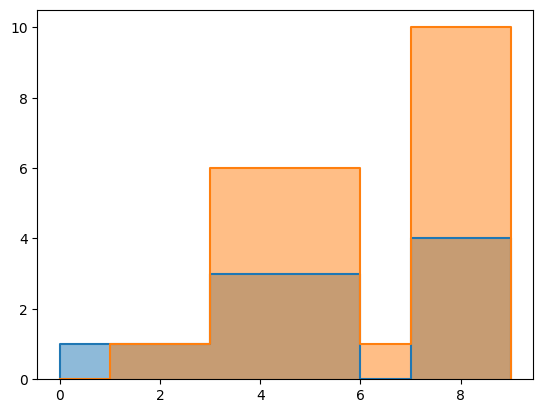

In [12]:
out_bins_2d = xr.apply_ufunc(
    bq.core.rebin._rebin_listmode,
    in_bins_2d,
    in_edges,
    out_edges[:-1],
    input_core_dims=[["bin"], [], []],
    output_core_dims=[["out_bin"]],
    dask="parallelized",
    output_dtypes=[int],
)

plot_rebin(out_bins_2d, [out_edges] * 2, lim=(0, 10.5))